In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import json
from cryptocompy import coin,price
import tqdm
import seaborn as sns
sns.set();

import io
import requests
import json
from datetime import datetime
import time
from time import gmtime, strftime

from sklearn import metrics
from fbprophet import Prophet
plt.rcParams["figure.figsize"] = [14,8]
pd.set_option('float_format', '{:f}'.format)

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import datetime
from datetime import datetime as dt
from datetime import timedelta


from tqdm import tqdm_notebook
from livelossplot.keras import PlotLossesCallback


from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
#from xgboost import XGBRegressor
from catboost import CatBoostRegressor, Pool, cv
import catboost
from sklearn.ensemble import RandomForestRegressor

from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json
#from sklearn.cross_validation import cross_val_score
#from sklearn.grid_search import GridSearchCV
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)

from keras.models import Sequential  
from keras.layers.core import Dense, Activation  
from keras.layers.recurrent import LSTM
from keras.layers.advanced_activations import LeakyReLU

from keras import optimizers
from keras import backend as K

adam = optimizers.Adam(lr=0.01, clipnorm=1.)

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 
def nn_r2_score(y_true, y_pred):
    total_error = K.sum(K.square( y_true - K.mean(y_true) ) )
    residual_error = K.sum(K.square( y_true - y_pred ))
    R_squared = 1 - (residual_error / total_error)
    return -R_squared

Using TensorFlow backend.


In [2]:
def supres(low, high, n=28, min_touches=2, stat_likeness_percent=1.5, bounce_percent=5):
    """Support and Resistance Testing
    Identifies support and resistance levels of provided price action data.
    Args:
        n(int): Number of frames to evaluate
        low(pandas.Series): A pandas Series of lows from price action data.
        high(pandas.Series): A pandas Series of highs from price action data.
        min_touches(int): Minimum # of touches for established S&R.
        stat_likeness_percent(int/float): Acceptable margin of error for level.
        bounce_percent(int/float): Percent of price action for established bounce.
    
    ** Note **
        If you want to calculate support and resistance without regard for
        candle shadows, pass close values for both low and high.
    Returns:
        sup(float): Established level of support or None (if no level)
        res(float): Established level of resistance or None (if no level)
    """
    import pandas as pd
    import numpy as np

    # Collapse into dataframe
    df = pd.concat([high, low], keys = ['high', 'low'], axis=1)
    df['sup'] = pd.Series(np.zeros(len(low)))
    df['res'] = pd.Series(np.zeros(len(low)))
    df['sup_break'] = pd.Series(np.zeros(len(low)))
    df['sup_break'] = 0
    df['res_break'] = pd.Series(np.zeros(len(high)))
    df['res_break'] = 0
    
    for x in range((n-1)+n, len(df)):
        # Split into defined timeframes for analysis
        tempdf = df[x-n:x+1]
        
        # Setting default values for support and resistance to None
        sup = None
        res = None
        
        # Identifying local high and local low
        maxima = tempdf.high.max()
        minima = tempdf.low.min()
        
        # Calculating distance between max and min (total price movement)
        move_range = maxima - minima
        
        # Calculating bounce distance and allowable margin of error for likeness
        move_allowance = move_range * (stat_likeness_percent / 100)
        bounce_distance = move_range * (bounce_percent / 100)
        
        # Test resistance by iterating through data to check for touches delimited by bounces
        touchdown = 0
        awaiting_bounce = False
        for y in range(0, len(tempdf)):
            if abs(maxima - tempdf.high.iloc[y]) < move_allowance and not awaiting_bounce:
                touchdown = touchdown + 1
                awaiting_bounce = True
            elif abs(maxima - tempdf.high.iloc[y]) > bounce_distance:
                awaiting_bounce = False
        if touchdown >= min_touches:
            res = maxima
        # Test support by iterating through data to check for touches delimited by bounces
        touchdown = 0
        awaiting_bounce = False
        for y in range(0, len(tempdf)):
            if abs(tempdf.low.iloc[y] - minima) < move_allowance and not awaiting_bounce:
                touchdown = touchdown + 1
                awaiting_bounce = True
            elif abs(tempdf.low.iloc[y] - minima) > bounce_distance:
                awaiting_bounce = False
        if touchdown >= min_touches:
            sup = minima
        if sup:
            df['sup'].iloc[x] = sup
        if res:
            df['res'].iloc[x] = res
    res_break_indices = list(df[(np.isnan(df['res']) & ~np.isnan(df.shift(1)['res'])) & (df['high'] > df.shift(1)['res'])].index)
    for index in res_break_indices:
        df['res_break'].at[index] = 1
    sup_break_indices = list(df[(np.isnan(df['sup']) & ~np.isnan(df.shift(1)['sup'])) & (df['low'] < df.shift(1)['sup'])].index)
    for index in sup_break_indices:
        df['sup_break'].at[index] = 1
    ret_df = pd.concat([df['sup'], df['res'], df['sup_break'], df['res_break']], keys = ['sup', 'res', 'sup_break', 'res_break'], axis=1)
    return ret_df

In [3]:
import MySQLdb 
import sshtunnel
from sshtunnel import SSHTunnelForwarder

In [4]:
import MySQLdb 
import sshtunnel
from sshtunnel import SSHTunnelForwarder
import pandas as pd

df = pd.DataFrame()
with SSHTunnelForwarder(('206.189.186.74', 22), ssh_password='crypto1234', ssh_username='aagam', remote_bind_address=('127.0.0.1', 3306)) as server:
    conn = MySQLdb.connect(host='localhost', port=server.local_bind_port, user='ianbalina', passwd='5!sT3jt26K%tFN*W',db='ianbalina')
    cursor = conn.cursor()
    
    #cursor.execute("SELECT * FROM ianbalina.ico_price_daily_summaries;") 
    #m = cursor.fetchone()
    query = '''SELECT * FROM ianbalina.ico_price_daily_summaries;'''
    data = pd.read_sql_query(query, conn)
    df = pd.concat([df,data])
    conn.close() 

I0910 07:33:21.640933 32084 transport.py:1819] Connected (version 2.0, client OpenSSH_7.6p1)
I0910 07:33:23.175721 32084 transport.py:1819] Authentication (password) successful!


In [5]:
d1 = pd.DataFrame()
with SSHTunnelForwarder(('206.189.186.74', 22), ssh_password='crypto1234', ssh_username='aagam', remote_bind_address=('127.0.0.1', 3306)) as server:
    conn = MySQLdb.connect(host='localhost', port=server.local_bind_port, user='ianbalina', passwd='5!sT3jt26K%tFN*W',db='ianbalina')
    cursor = conn.cursor()
    
    #cursor.execute("SELECT * FROM ianbalina.ico_price_daily_summaries;") 
    #m = cursor.fetchone()
    query = '''SELECT * FROM ianbalina.ico_technical_analyses;'''
    data = pd.read_sql_query(query, conn)
    d1 = pd.concat([d1,data])
    conn.close() 

I0910 07:33:54.616543  3104 transport.py:1819] Connected (version 2.0, client OpenSSH_7.6p1)
I0910 07:33:56.760050  3104 transport.py:1819] Authentication (password) successful!


In [6]:
d2 = pd.DataFrame()
with SSHTunnelForwarder(('206.189.186.74', 22), ssh_password='crypto1234', ssh_username='aagam', remote_bind_address=('127.0.0.1', 3306)) as server:
    conn = MySQLdb.connect(host='localhost', port=server.local_bind_port, user='ianbalina', passwd='5!sT3jt26K%tFN*W',db='ianbalina')
    cursor = conn.cursor()
    
    #cursor.execute("SELECT * FROM ianbalina.ico_price_daily_summaries;") 
    #m = cursor.fetchone()
    query = '''SELECT * FROM ianbalina.technical_analysis_scoring;'''
    data = pd.read_sql_query(query, conn)
    d2 = pd.concat([d2,data])
    conn.close() 

I0910 07:34:16.936624 33260 transport.py:1819] Connected (version 2.0, client OpenSSH_7.6p1)
I0910 07:34:19.802484 33260 transport.py:1819] Authentication (password) successful!


In [7]:
d3 = pd.DataFrame()
with SSHTunnelForwarder(('206.189.186.74', 22), ssh_password='crypto1234', ssh_username='aagam', remote_bind_address=('127.0.0.1', 3306)) as server:
    conn = MySQLdb.connect(host='localhost', port=server.local_bind_port, user='ianbalina', passwd='5!sT3jt26K%tFN*W',db='ianbalina')
    cursor = conn.cursor()
    
    #cursor.execute("SELECT * FROM ianbalina.ico_price_daily_summaries;") 
    #m = cursor.fetchone()
    query = '''SELECT * FROM ianbalina.technical_analysis_weights;'''
    data = pd.read_sql_query(query, conn)
    d3 = pd.concat([d3,data])
    conn.close() 

I0910 07:34:23.489389  9936 transport.py:1819] Connected (version 2.0, client OpenSSH_7.6p1)
I0910 07:34:25.332878  9936 transport.py:1819] Authentication (password) successful!


In [52]:
d3

,id,indicator,weight,created_at,updated_at
0,1,adx,4.000000,None,None
1,2,ao,2.000000,None,None
2,3,cci,1.000000,None,None
3,4,macd,11.000000,None,None
4,5,fi,1.000000,None,None
5,6,rsi,3.000000,None,None
6,7,kd,7.000000,None,None
7,8,wr,2.000000,None,None
8,9,roc,1.000000,None,None
9,10,trix,10.000000,None,None


In [8]:
candlestick = pd.DataFrame()
with SSHTunnelForwarder(('206.189.186.74', 22), ssh_password='crypto1234', ssh_username='aagam', remote_bind_address=('127.0.0.1', 3306)) as server:
    conn = MySQLdb.connect(host='localhost', port=server.local_bind_port, user='ianbalina', passwd='5!sT3jt26K%tFN*W',db='ianbalina')
    cursor = conn.cursor()
    
    #cursor.execute("SELECT * FROM ianbalina.ico_price_daily_summaries;") 
    #m = cursor.fetchone()
    query = '''SELECT * FROM ianbalina.ico_candlestick_patterns;'''
    data = pd.read_sql_query(query, conn)
    candlestick = pd.concat([candlestick,data])
    conn.close() 

I0910 07:34:28.964905 34096 transport.py:1819] Connected (version 2.0, client OpenSSH_7.6p1)
I0910 07:34:30.991578 34096 transport.py:1819] Authentication (password) successful!


In [70]:
d1 = d1[d1['date'] == datetime.date(2019,8,19)]
d3['indicator'].iloc[11] = 'ichimoku_lagging_span'
d4 = pd.merge(d1,d3[['indicator','weight']], on=['indicator'] ,how='left')
d4['signal'] = d4['signal'].replace(['neutral','downward','upward','buy','sell'],[0,-25,25,75,-75])

In [71]:
candlestick['signal'] = candlestick['signal'].replace(['bullish','bearish','bearish_bullish'],[25,-25,0])

TypeError: Cannot compare types 'ndarray(dtype=int64)' and 'str'

In [72]:
candlestick['signal']

0       25
1      -25
2       25
3       25
4      -25
5       25
6      -25
7      -25
8      -25
9       25
10     -25
11      25
12      25
13     -25
14     -25
15      25
16      25
17     -25
18     -25
19      25
20     -25
21      25
22     -25
23      25
24      25
25      25
26     -25
27      25
28      25
29     -25
30      25
31      25
32     -25
33       0
34     -25
35     -25
36      25
37      25
38     -25
39      25
40       0
41     -25
42     -25
43      25
44       0
45      25
46     -25
47      25
48       0
49      25
50      25
51      25
52      25
53      25
54     -25
55      25
56     -25
57      25
58      25
59      25
60      25
61      25
62      25
63     -25
64      25
65     -25
66      25
67     -25
68      25
69      25
70      25
71      25
72      25
73      25
74      25
75      25
76     -25
77      25
78      25
79     -25
80      25
81      25
82      25
83     -25
84      25
85      25
86       0
87      25
88     -25
89      25
90      25

num = df['ico_id'][df['ico_symbol'] == 'BTC'].unique().tolist()
d5 = d4[d4['ico_id'].isin(num)]
d5 = d5[['indicator','weight','signal']]

candlestick['weight'] = 1
t1 = candlestick[candlestick['ico_id'].isin(num)]
t1 = t1[['pattern','weight','signal']]
t1.columns = d5.columns

d5 = pd.concat([d5,t1])
d5 = d5.drop_duplicates('indicator')
d5['weight'] = d5['weight'].fillna(1)
d5 = d5.fillna(0)

In [73]:
temp = pd.DataFrame()
for coin in df['ico_symbol'].unique().tolist():
    num = df['ico_id'][df['ico_symbol'] == coin].unique().tolist()
    d5 = d4[d4['ico_id'].isin(num)]
    d5 = d5[['indicator','weight','signal']]
    
    candlestick['weight'] = 1
    t1 = candlestick[candlestick['ico_id'].isin(num)]
    t1 = t1[['pattern','weight','signal']]
    t1.columns = d5.columns
    
    d5 = pd.concat([d5,t1])
    
    d5 = d5.drop_duplicates('indicator')
    d5['weight'] = d5['weight'].fillna(1)
    d5 = d5.fillna(0)
    temp = pd.concat([temp,pd.DataFrame([coin,sum(d5['weight'] * d5['signal'].astype('float64')) / d5['weight'].sum()])], axis=1)

In [74]:
temp = temp.T
temp.columns = ['Coins','Technical Score']
temp.dropna(inplace=True)

t2 = pd.DataFrame()
for coin in temp['Coins']:
    t1 = df[df['ico_symbol'] == coin]
    t1 = t1[t1['date'] >= datetime.date(2019,8,19)][t1['date'] <= datetime.date(2019,8,27)]
    t1 = t1.drop_duplicates(subset=['date'])
    if len(t1) > 1:
        x1 = t1['close'].iloc[-1] - t1['close'].iloc[0]
        x2 = (t1['close'].iloc[-1] - t1['close'].iloc[0]) / t1['close'].iloc[0] * 100
        t2 = pd.concat([t2,pd.DataFrame([coin,x1,x2])], axis=1)
        
t2 = t2.T
t2.columns = ['Coins','Price Change', '% Change']
final = pd.merge(temp,t2)

In [75]:
final

,Coins,Technical Score,Price Change,% Change
0,BTC,-40.291262,84.120117,0.816163
1,ETH,69.852941,-3.724014,-1.914522
2,OMG,68.509615,0.005200,0.414841
3,EOS,68.932039,-0.062410,-1.690044
4,LTC,71.323529,-2.010002,-2.635032
5,XMR,-22.815534,-5.801704,-6.603569
6,DASH,71.323529,-2.809998,-2.969144
7,NEO,69.852941,-0.012730,-0.129251
8,ZEC,69.417476,-0.740101,-1.403705
9,BTG,68.028846,-0.597060,-4.312125


#### Thresholds

In [40]:
a1 = pd.DataFrame()
with SSHTunnelForwarder(('206.189.186.74', 22), ssh_password='crypto1234', ssh_username='aagam', remote_bind_address=('127.0.0.1', 3306)) as server:
    conn = MySQLdb.connect(host='localhost', port=server.local_bind_port, user='ianbalina', passwd='5!sT3jt26K%tFN*W',db='ianbalina')
    cursor = conn.cursor()
    
    #cursor.execute("SELECT * FROM ianbalina.ico_price_daily_summaries;") 
    #m = cursor.fetchone()
    query = '''SELECT * FROM ianbalina.technical_analysis_final_indicator_thresholds;'''
    data = pd.read_sql_query(query, conn)
    a1 = pd.concat([a1,data])
    conn.close() 

I0910 08:22:13.113816  8532 transport.py:1819] Connected (version 2.0, client OpenSSH_7.6p1)
I0910 08:22:14.946688  8532 transport.py:1819] Authentication (password) successful!


In [41]:
a1

,id,signal,threshold_low,threshold_high,created_at,updated_at
0,1,strong_sell,-100.000000,-50.000000,None,None
1,2,sell,-50.000000,-10.000000,None,None
2,3,neutral,-10.000000,10.000000,None,None
3,4,buy,10.000000,50.000000,None,None
4,5,strong_buy,50.000000,100.000000,None,None


In [76]:
def fun(x):
    if x < -50:
        return 'Strong Sell'
    elif x > -50  and x < -10:
        return 'Sell'
    elif x > -10 and x < 10:
        return 'Neutral'
    elif x > 10 and x < 50:
        return 'Buy'
    else:
        return 'Strong Buy'

In [ ]:
Neutral -> -5 to +5
Positive -> +5 to +15
Negative -> -5 to -15

In [77]:
a2 = pd.DataFrame()
a2['id'] = a1['id']
a2['signal'] = ['Strong Negative returns','Negative returns', 'Neutral',  'Positive returns',
               'Strong Positive returns']
a2['threshold_low'] = [-100,-15,-5,5,15]
a2['threshold_high'] = [-15,-5,5,15,100]
a2

,id,signal,threshold_low,threshold_high
0,1,Strong Negative returns,-100,-15
1,2,Negative returns,-15,-5
2,3,Neutral,-5,5
3,4,Positive returns,5,15
4,5,Strong Positive returns,15,100


In [78]:
final['TA result'] = final['Technical Score'].apply(fun)

In [79]:
def fun1(x,v1,v2,v3,v4):
    if x < v1:
        return 'Strong Negative returns'
    elif x > v1 and x < v2:
        return 'Negative returns'
    elif x > v2 and x < v3:
        return 'Neutral'
    elif x > v3 and x < v4:
        return 'Positive returns'
    else:
        return 'Strong Positive returns'

In [80]:
final['Actual result'] = final['% Change'].apply(fun1,args=[-15,-5,5,15])

In [81]:
final

,Coins,Technical Score,Price Change,% Change,TA result,Actual result
0,BTC,-40.291262,84.120117,0.816163,Sell,Neutral
1,ETH,69.852941,-3.724014,-1.914522,Strong Buy,Neutral
2,OMG,68.509615,0.005200,0.414841,Strong Buy,Neutral
3,EOS,68.932039,-0.062410,-1.690044,Strong Buy,Neutral
4,LTC,71.323529,-2.010002,-2.635032,Strong Buy,Neutral
5,XMR,-22.815534,-5.801704,-6.603569,Sell,Negative returns
6,DASH,71.323529,-2.809998,-2.969144,Strong Buy,Neutral
7,NEO,69.852941,-0.012730,-0.129251,Strong Buy,Neutral
8,ZEC,69.417476,-0.740101,-1.403705,Strong Buy,Neutral
9,BTG,68.028846,-0.597060,-4.312125,Strong Buy,Neutral


In [82]:
def acc(x):
    if x.name == 'Strong Sell' or x.name == 'Sell':
        return (x['Strong Negative returns'] + x['Negative returns']) / x['Total']
    elif x.name == 'Neutral':
        return (x['Neutral']) / x['Total']
    else:
        return (x['Strong Positive returns'] + x['Positive returns']) / x['Total']

In [83]:
data = pd.crosstab(final['TA result'], final['Actual result'])

data = data.reindex(['Strong Sell','Sell','Neutral','Buy','Strong Buy'])
data = data.reindex(columns=['Strong Negative returns', 'Negative returns', 'Neutral', 'Positive returns',
                             'Strong Positive returns'])

data['Total'] = data.sum(axis=1)
data['% Accurate'] = data.T.apply(acc) * 100
data.fillna(0,inplace=True)
data

Actual result,Strong Negative returns,Negative returns,Neutral,Positive returns,Strong Positive returns,Total,% Accurate
TA result,,,,,,,
Strong Sell,1,1,3,0,0,5,40.000000
Sell,1,2,3,1,2,9,33.333333
Neutral,3,7,9,2,3,24,37.500000
Buy,2,6,28,9,8,53,32.075472
Strong Buy,2,4,50,7,7,70,20.000000


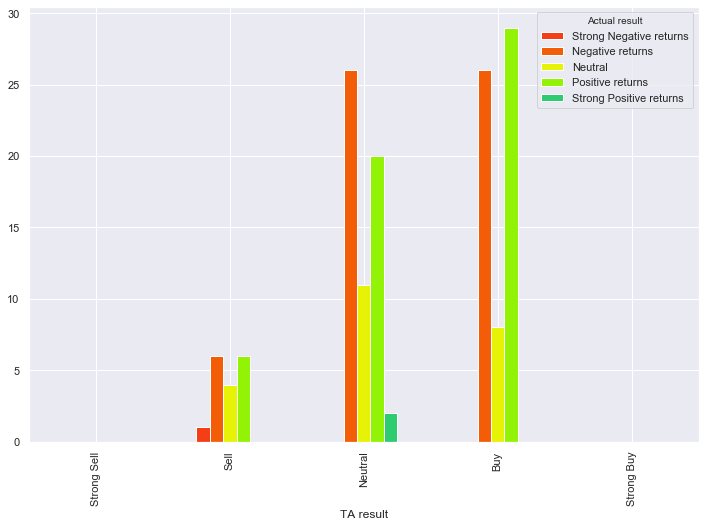

In [22]:
flatui = ["#F33E17", "#F35D07","#E6F307", "#93F307","#2ecc71"]
sns.set_palette(sns.color_palette(flatui))
data.iloc[:,:5].plot(kind='bar', figsize=(12,8))

In [23]:
final['Actual result'].unique()

array(['Neutral', 'Negative returns', 'Positive returns',
       'Strong Positive returns', 'Strong Negative returns'], dtype=object)

In [487]:
p1 = final['TA result'].map({'Strong Sell':1,'Sell':2,'Neutral':3,'Buy':4,'Strong Buy':5})
p2 = final['Actual result'].map({'Strong Negative returns':1, 'Negative returns':2, 'Neutral':3, 'Positive returns':4,
                                'Strong Positive returns': 5})
metrics.accuracy_score(p1,p2)

0.18633540372670807

### Genetic

In [53]:
from math import sin, cos

from gaft import GAEngine
from gaft.components import BinaryIndividual,DecimalIndividual
from gaft.components import Population
from gaft.operators import TournamentSelection, LinearRankingSelection
from gaft.operators import UniformCrossover
from gaft.operators import FlipBitMutation
from gaft.analysis import ConsoleOutput

# Analysis plugin base class.
from gaft.plugin_interfaces.analysis import OnTheFlyAnalysis

# Built-in best fitness analysis.
from gaft.analysis.fitness_store import FitnessStore

import MySQLdb 
import sshtunnel
from sshtunnel import SSHTunnelForwarder

In [90]:
def fun(x):
    if x < -50:
        return 'Strong Sell'
    elif x > -50  and x < -10:
        return 'Sell'
    elif x > -10 and x < 10:
        return 'Neutral'
    elif x > 10 and x < 50:
        return 'Buy'
    else:
        return 'Strong Buy'
    
def fun1(x,v1,v2,v3,v4):
    if x < v1:
        return 'Strong Negative returns'
    elif x > v1 and x < v2:
        return 'Negative returns'
    elif x > v2 and x < v3:
        return 'Neutral'
    elif x > v3 and x < v4:
        return 'Positive returns'
    else:
        return 'Strong Positive returns'
    
    
def acc(x):
    if x.name == 'Strong Sell' or x.name == 'Sell':
        return (x['Strong Negative returns'] + x['Negative returns']) / x['Total']
    elif x.name == 'Neutral':
        return (x['Neutral']) / x['Total']
    else:
        return (x['Strong Positive returns'] + x['Positive returns']) / x['Total']

In [91]:
df = pd.DataFrame()
d1 = pd.DataFrame()
d2 = pd.DataFrame()
d3 = pd.DataFrame()
candlestick = pd.DataFrame()

with SSHTunnelForwarder(('206.189.186.74', 22), ssh_password='crypto1234', ssh_username='aagam', remote_bind_address=('127.0.0.1', 3306)) as server:
    conn = MySQLdb.connect(host='localhost', port=server.local_bind_port, user='ianbalina', passwd='5!sT3jt26K%tFN*W',db='ianbalina')
    cursor = conn.cursor()
    
    #cursor.execute("SELECT * FROM ianbalina.ico_price_daily_summaries;") 
    #m = cursor.fetchone()
    query = '''SELECT * FROM ianbalina.ico_price_daily_summaries;'''
    data = pd.read_sql_query(query, conn)
    df = pd.concat([df,data])
    
    
    query = '''SELECT * FROM ianbalina.ico_technical_analyses;'''
    data = pd.read_sql_query(query, conn)
    d1 = pd.concat([d1,data])
    
    query = '''SELECT * FROM ianbalina.technical_analysis_scoring;'''
    data = pd.read_sql_query(query, conn)
    d2 = pd.concat([d2,data])
    
    query = '''SELECT * FROM ianbalina.technical_analysis_weights;'''
    data = pd.read_sql_query(query, conn)
    d3 = pd.concat([d3,data])
    
    query = '''SELECT * FROM ianbalina.ico_candlestick_patterns;'''
    data = pd.read_sql_query(query, conn)
    candlestick = pd.concat([candlestick,data])
    
    conn.close() 

I0910 08:42:27.563187 31724 transport.py:1819] Connected (version 2.0, client OpenSSH_7.6p1)
I0910 08:42:29.238078 31724 transport.py:1819] Authentication (password) successful!


In [92]:
d3['indicator'].iloc[11] = 'ichimoku_lagging_span'
candlestick['signal'] = candlestick['signal'].replace(['bullish','bearish','bearish_bullish'],[25,-25,0])
d1 = d1[d1['date'] == datetime.date(2019,8,19)]

In [96]:
def get_result(x = [4,2,1,11,1,3,7,2,1,10,7,21,25,6]):
    d3['weight'] = x
    d4 = pd.merge(d1,d3[['indicator','weight']], on=['indicator'] ,how='left')
    d4['signal'] = d4['signal'].replace(['neutral','downward','upward','buy','sell'],[0,-25,25,75,-75])

    
    temp = pd.DataFrame()
    for coin in df['ico_symbol'].unique().tolist():
        num = df['ico_id'][df['ico_symbol'] == coin].unique().tolist()
        d5 = d4[d4['ico_id'].isin(num)]
        d5 = d5[['indicator','weight','signal']]

        candlestick['weight'] = 1
        t1 = candlestick[candlestick['ico_id'].isin(num)]
        t1 = t1[['pattern','weight','signal']]
        t1.columns = d5.columns

        d5 = pd.concat([d5,t1])

        d5 = d5.drop_duplicates('indicator')
        d5['weight'] = d5['weight'].fillna(1)
        d5 = d5.fillna(0)
        temp = pd.concat([temp,pd.DataFrame([coin,sum(d5['weight'] * d5['signal'].astype('float64')) / d5['weight'].sum()])], axis=1)
        
        
    temp = temp.T
    temp.columns = ['Coins','Technical Score']
    temp.dropna(inplace=True)

    t2 = pd.DataFrame()
    for coin in temp['Coins']:
        t1 = df[df['ico_symbol'] == coin]
        t1 = t1[t1['date'] >= datetime.date(2019,8,19)][t1['date'] <= datetime.date(2019,8,27)]
        t1 = t1.drop_duplicates(subset=['date'])
        if len(t1) > 1:
            x1 = t1['close'].iloc[-1] - t1['close'].iloc[0]
            x2 = (t1['close'].iloc[-1] - t1['close'].iloc[0]) / t1['close'].iloc[0] * 100
            t2 = pd.concat([t2,pd.DataFrame([coin,x1,x2])], axis=1)

    t2 = t2.T
    t2.columns = ['Coins','Price Change', '% Change']
    final = pd.merge(temp,t2)
    
    final['TA result'] = final['Technical Score'].apply(fun)
    final['Actual result'] = final['% Change'].apply(fun1,args=[-15,-5,5,15])
    
    data = pd.crosstab(final['TA result'], final['Actual result'])

    data = data.reindex(['Strong Sell','Sell','Neutral','Buy','Strong Buy'])
    data = data.reindex(columns=['Strong Negative returns', 'Negative returns', 'Neutral', 'Positive returns',
                                 'Strong Positive returns'])

    data['Total'] = data.sum(axis=1)
    data['% Accurate'] = data.T.apply(acc) * 100
    data.fillna(0,inplace=True)
    return data

In [114]:
x = get_result([18, 18, 16, 11, 18, 14, 7, 16, 25, 21, 5, 19, 1, 2] )

In [115]:
x

Actual result,Strong Negative returns,Negative returns,Neutral,Positive returns,Strong Positive returns,Total,% Accurate
TA result,,,,,,,
Strong Sell,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Sell,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000
Neutral,9.000000,20.000000,85.000000,17.000000,14.000000,145.000000,58.620690
Buy,0.000000,0.000000,7.000000,2.000000,4.000000,13.000000,46.153846
Strong Buy,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000


In [104]:
sum(x['Total'] * x['% Accurate'] / 100)

45.0

In [107]:
len(d3)

14

[(0, 25),
 (0, 25),
 (0, 25),
 (0, 25),
 (0, 25),
 (0, 25),
 (0, 25),
 (0, 25),
 (0, 25),
 (0, 25),
 (0, 25),
 (0, 25),
 (0, 25),
 (0, 25)]

In [113]:
indv_template = DecimalIndividual(ranges=[(0,25)]*14, eps=[1]*14)
population = Population(indv_template=indv_template, size=4).init()

selection = LinearRankingSelection()
crossover = UniformCrossover(pc=0.8, pe=0.5)
mutation = FlipBitMutation(pm=0.1)

# Create genetic algorithm engine.
engine = GAEngine(population=population, selection=selection,
                  crossover=crossover, mutation=mutation,
                  analysis=[FitnessStore])

@engine.fitness_register
#@engine.maximize
def fitness(indv):
    w = list(indv.solution)
    res = get_result(w)
    res = sum(res['Total'] * res['% Accurate'] / 100)
    res = float(abs(res))
    print(w,': ',res)
    return res

def get_test_results(w):
    res = get_result(w)
    print('\nRight Coins: ', sum(res['Total'] * res['% Accurate'] / 100))
    print(res)

# Define on-the-fly analysis.
@engine.analysis_register
class ConsoleOutputAnalysis(OnTheFlyAnalysis):
    interval = 1
    master_only = True

    def register_step(self, g, population, engine):
        best_indv = population.best_indv(engine.fitness)
        msg = 'Generation: {}, best fitness: {:.3f}'.format(g, engine.ori_fmax)
        self.logger.info(msg)

    def finalize(self, population, engine):
        best_indv = population.best_indv(engine.fitness)
        x = best_indv.solution
        y = engine.fmax
        msg = 'Optimal solution: ({}, {})'.format(x, y)
        self.logger.info(msg)

if '__main__' == __name__:
    # Run the GA engine.
    engine.run(ng=1)
    best_indv = engine.population.best_indv(engine.fitness)
    w = list(best_indv.solution)
    get_test_results(w)

[6, 25, 5, 19, 5, 18, 14, 14, 3, 22, 19, 23, 16, 14] :  46.0
[19, 7, 0, 0, 20, 8, 5, 20, 15, 8, 0, 4, 5, 20] :  81.00000000000001
[18, 8, 6, 4, 15, 0, 20, 4, 17, 24, 18, 14, 5, 16] :  78.0
[19, 20, 10, 4, 13, 13, 22, 7, 0, 8, 13, 25, 13, 14] :  46.0
[19, 7, 0, 0, 20, 8, 5, 20, 15, 8, 0, 4, 5, 20] :  81.00000000000001
[16, 14, 8, 14, 21, 18, 4, 24, 19, 10, 13, 17, 6, 5] :  83.00000000000001
[18, 10, 18, 8, 14, 21, 5, 8, 9, 25, 13, 1, 3, 21] :  88.0
[24, 13, 17, 24, 17, 3, 7, 10, 21, 15, 16, 25, 10, 24] :  59.0
gaft.ConsoleOutputAnalysis   INFO     Generation: 0, best fitness: 88.000


I0910 09:38:20.073806 27956 <ipython-input-113-7a94aae0737f>:37] Generation: 0, best fitness: 88.000


gaft.FitnessStore   INFO     Best fitness values are written to best_fit.py


I0910 09:38:20.077806 27956 fitness_store.py:48] Best fitness values are written to best_fit.py


gaft.ConsoleOutputAnalysis   INFO     Optimal solution: ([18, 10, 18, 8, 14, 21, 5, 8, 9, 25, 13, 1, 3, 21], 88.0)


I0910 09:38:20.081845 27956 <ipython-input-113-7a94aae0737f>:44] Optimal solution: ([18, 10, 18, 8, 14, 21, 5, 8, 9, 25, 13, 1, 3, 21], 88.0)



Right Coins:  88.0
Actual result  Strong Negative returns  Negative returns   Neutral  Positive returns  Strong Positive returns      Total  % Accurate
TA result                                                                                                                           
Strong Sell                   0.000000          0.000000  0.000000          0.000000                 0.000000   0.000000    0.000000
Sell                          0.000000          0.000000  0.000000          0.000000                 2.000000   2.000000    0.000000
Neutral                       7.000000         20.000000 81.000000         16.000000                14.000000 138.000000   58.695652
Buy                           2.000000          0.000000 12.000000          3.000000                 4.000000  21.000000   33.333333
Strong Buy                    0.000000          0.000000  0.000000          0.000000                 0.000000   0.000000    0.000000
